# Sentiment analysis

In [1]:
import urllib.request
import csv
import re
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load graph:
S = pickle.load(open("graph.pkl", "rb"))
DOWNLOADS_DIR = "downloads"

In [2]:
# Download the LabMT wordlist (with happiness scores)
file_id = "1fEW8gxKEfwiNRgpeqQ1S9qbATyrNftoE"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
local_filename = "labmt_wordlist.txt"
urllib.request.urlretrieve(url, local_filename)

('labmt_wordlist.txt', <http.client.HTTPMessage at 0x1d3e9859190>)

In [3]:
# This function reads the wordlist and creates a dictionary
def load_labmt_wordlist(file_path):
    labmt_dict = {}
    with open(file_path, 'r') as file:
        reader = csv.reader(file, delimiter='\t')
        # Skip the first four lines
        for _ in range(4):
          next(reader)
        for row in reader:
            # Check if the row has the expected number of columns
            if len(row) < 3:
                print(f"Skipping row due to insufficient columns: {row}")
                continue
            word = row[0].lower()  # Lowercase the word for consistency
            try:
                score = float(row[2])  # Happiness average is in the third column
                labmt_dict[word] = score
            except ValueError:
                # Handle case where score is not a valid float
                print(f"Skipping row due to invalid score: {row}")
                continue
    return labmt_dict

In [4]:
# Load the LabMT wordlist into memory
labmt_wordlist = load_labmt_wordlist(local_filename)

# # Check to ensure the list is loaded correctly
# print(list(labmt_wordlist.items())[:10])


In [5]:
# This function will return a list of words for each philosopher's page, ready for sentiment scoring
def clean_and_tokenize(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    tokens = text.split()  # Tokenize (split into words)
    return tokens

# Calculate sentiment based on the LabMT wordlist
def calculate_sentiment(tokens, labmt_dict):
    scores = [labmt_dict[word] for word in tokens if word in labmt_dict]
    return sum(scores) / len(scores) if scores else None

# Calculate the sentiment SCORE and store it as a node ATTRIBUTE
def process_graph(graph, labmt_wordlist):
    processed_count = 0  # Initialize counter for processed philosopher

    for node in graph.nodes:
        philosopher_name = node
        philosopher_file_name = philosopher_name.replace(' ', '_') + ".txt"  # Format the philosopher file name
        philosopher_file_path = os.path.join(DOWNLOADS_DIR, philosopher_file_name)  # Prepend directory path

        # Check if the file exists for this philosopher
        if os.path.exists(philosopher_file_path):
            try:
                # Read the text file content
                with open(philosopher_file_path, 'r', encoding='utf-8') as f:
                    text = f.read()

                    # Tokenize the text
                    tokens = clean_and_tokenize(text)

                    # Calculate sentiment
                    sentiment = calculate_sentiment(tokens, labmt_wordlist)

                    # Store sentiment in the graph node
                    graph.nodes[node]["sentiment"] = sentiment
                    processed_count += 1  # Increment processed count

            except Exception as e:
                print(f"Error processing file for {philosopher_name}: {e}")
        else:
            print(f"File not found for artist: {philosopher_name} ({philosopher_file_name})")

    print(f"\nTotal artists processed: {processed_count} out of {len(graph.nodes)}")


In [6]:
# Example of running the function
process_graph(S, labmt_wordlist)

# What the nodes look like now
print(list(S.nodes(data=True))[256])


Total artists processed: 1366 out of 1366
('Paul_Deussen', {'contentlength': 980, 'sentiment': 5.344014869888484})


## Some statistics

In [7]:
# Collect all valid sentiment scores from the graph
sentiment_scores = [
    S.nodes[node]["sentiment"]
    for node in S.nodes
    if S.nodes[node]["sentiment"] is not None
]

# Calculate key statistics
mean_sentiment = np.mean(sentiment_scores)
median_sentiment = np.median(sentiment_scores)
variance_sentiment = np.var(sentiment_scores)
percentile_25 = np.percentile(sentiment_scores, 25)
percentile_75 = np.percentile(sentiment_scores, 75)

# Print the statistics
print(f"Mean: {mean_sentiment:.2f}")
print(f"Median: {median_sentiment:.2f}")
print(f"Variance: {variance_sentiment:.2f}")
print(f"25th Percentile: {percentile_25:.2f}")
print(f"75th Percentile: {percentile_75:.2f}")

Mean: 5.42
Median: 5.41
Variance: 0.01
25th Percentile: 5.37
75th Percentile: 5.46


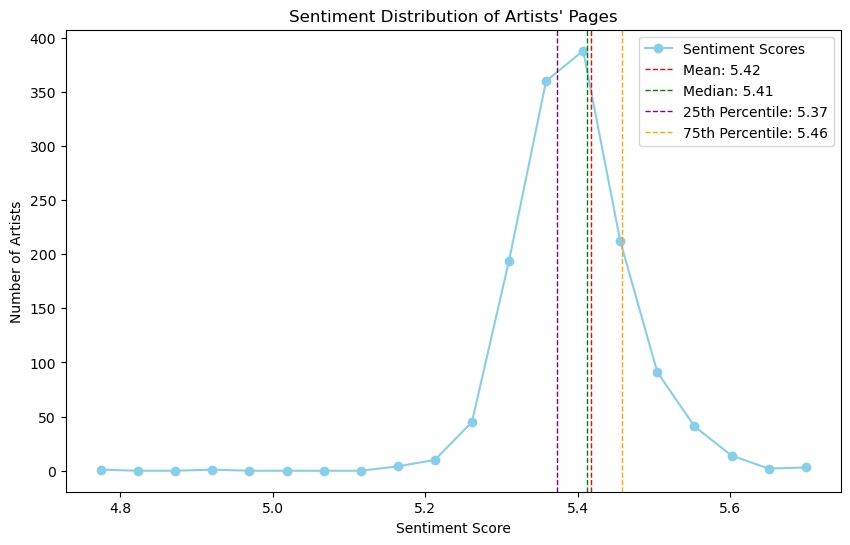

In [8]:
# A graph to represent the distribution of sentiment scores
bins = np.linspace(min(sentiment_scores), max(sentiment_scores), 21)  # 20 bins
hist_values, bin_edges = np.histogram(sentiment_scores, bins=bins)

plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], hist_values, marker='o', color='skyblue', linestyle='-', label="Sentiment Scores")

plt.axvline(mean_sentiment, color='red', linestyle='dashed', linewidth=1, label=f"Mean: {mean_sentiment:.2f}")
plt.axvline(median_sentiment, color='green', linestyle='dashed', linewidth=1, label=f"Median: {median_sentiment:.2f}")
plt.axvline(percentile_25, color='purple', linestyle='dashed', linewidth=1, label=f"25th Percentile: {percentile_25:.2f}")
plt.axvline(percentile_75, color='orange', linestyle='dashed', linewidth=1, label=f"75th Percentile: {percentile_75:.2f}")

plt.xlabel("Sentiment Score")
plt.ylabel("Number of Artists")
plt.title("Sentiment Distribution of Artists' Pages")
plt.legend()
plt.show()


In [9]:
# Sort nodes by sentiment score to find happiest and saddest philosophers
sorted_sentiment = sorted(
    [(node, S.nodes[node]["sentiment"]) for node in S.nodes if S.nodes[node]["sentiment"] is not None],
    key=lambda x: x[1],
    reverse=True
)

# Get the top 4 happiest and saddest philosophers
happiest_philosophes = sorted_sentiment[:4]
saddest_philosophers = sorted_sentiment[-4:]

# Print the results
print("Top 4 Happiest Philosophers:")
for artist, score in happiest_philosophes:
    print(f"{artist}: {score:.2f}")

print("\nTop 4 Saddest Philosophers:")
for artist, score in saddest_philosophers:
    print(f"{artist}: {score:.2f}")


Top 4 Happiest Philosophers:
The_Oxford_Companion_to_Philosophy: 5.75
The_Cambridge_Dictionary_of_Philosophy: 5.72
Ram_Gopal_Varma: 5.71
Richard_Schacht: 5.68

Top 4 Saddest Philosophers:
Hervaeus_Natalis: 5.19
Heinrich_Rickert: 5.17
Dietrich_of_Freiberg: 4.94
Stanislaw_Lesniewski: 4.78


## Community sentiment analysis

In [13]:
from collections import Counter
import pickle

with open("philosophers_subfield_data.pkl", "rb") as file:
    philosopher_communities = pickle.load(file)

# Function to calculate the average sentiment for a specific community
def calculate_community_sentiment(graph, community_id, partition):
    community_nodes = [node for node, community in partition.items() if community == community_id]
    # Collect the pre-calculated sentiment for each node in the community
    sentiments = []
    for node in community_nodes:
      sentiment = graph.nodes[node].get("sentiment")
      if sentiment is not None:
        sentiments.append(sentiment)

    # Calculate the average sentiment for the community
    if sentiments:
      return np.mean(sentiments)
    else:
      return None

# Identify the 10 largest communities by size for focused analysis
hashable_communities = [tuple(community) for community in philosopher_communities.values()]

# Ora usa Counter
community_sizes = Counter(hashable_communities)
print(community_sizes)
largest_communities = [community for community, _ in community_sizes.most_common(10)]
print("The 10 largest communities are:", largest_communities)

# Calculate sentiment for each of the 10 largest communities
community_sentiments = {}
for community_id in largest_communities:
    avg_sentiment = calculate_community_sentiment(S, community_id, hashable_communities)
    community_sentiments[community_id] = avg_sentiment
    print(f"Community {community_id}: Avg Sentiment = {avg_sentiment:.3f}")

Counter({('Walter_Pater', 'Etienne_Gilson', 'Georg_Wilhelm_Friedrich_Hegel', 'Liu_Xie', 'Alexander_Gottlieb_Baumgarten', 'Abhinavagupta', 'Umberto_Eco', 'George_Santayana', 'Ferruccio_Busoni', 'Thomas_Reid', 'Johann_Friedrich_Herbart', 'Rudolf_Arnheim', 'Arthur_Schopenhauer', 'Victor_Cousin', 'Clive_Bell', 'August_Wilhelm_Schlegel', 'Viktor_Shklovsky', 'Maurice_Blanchot', 'Jacques_Maritain', 'Edmund_Burke', 'Vissarion_Belinsky', 'Karl_Wilhelm_Friedrich_von_Schlegel', 'John_Ruskin', 'Stanley_Cavell', 'Friedrich_Schiller', 'Harold_Bloom', 'Mani_Kaul', 'Michel_Foucault', 'Nelson_Goodman', 'Theodor_Adorno', 'Susanne_Langer', 'Georg_Anton_Friedrich_Ast', 'Ayn_Rand', 'Friedrich_Wilhelm_Joseph_von_Schelling', 'Yusuf_Balasagun', 'Plotinus', 'Siri_Hustvedt', 'George_Birkhoff', 'Eduard_Hanslick', 'Roger_Scruton', 'Immanuel_Kant', 'David_Hume', 'Friedrich_Nietzsche', 'Jacques_Derrida', 'Algernon_Charles_Swinburne', 'On_the_Sublime', 'Benedetto_Croce', 'Max_Black', 'Ralph_Waldo_Emerson', 'Plato', 

AttributeError: 'list' object has no attribute 'items'

In [14]:
print(type(philosopher_communities))

<class 'dict'>


In [15]:
community_sizes = Counter(philosopher_communities.values())


TypeError: unhashable type: 'list'